In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import ipywidgets

params = {
    "figure.figsize": (6, 4),
    "figure.dpi": 72,
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "font.size": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "savefig.bbox": "tight",
    "figure.constrained_layout.use": True,
}
plt.rcParams.update(params)

%matplotlib ipympl

interactive(children=(IntSlider(value=9999, description='epoch', max=9999), Output()), _dom_classes=('widget-i…

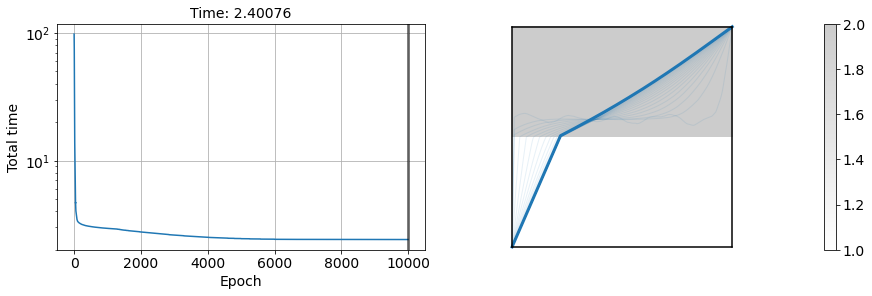

In [11]:
n_x = 201
x = torch.linspace(0, 1, n_x)
dx = torch.diff(x)
y = x.clone()[1:-1]
y = torch.rand_like(x)[1:-1]
y = torch.nn.Parameter(y)
y0 = torch.tensor(0.0)
y1 = torch.tensor(1.0)
n_epoch = 10000


def refraction_index(x, y):
    # return torch.where(y < 0.5, 1, 1)
    return torch.where(y < 0.5, 1, 2)
    # return torch.maximum(1 + y**2, torch.zeros_like(y))
    # r = torch.sqrt((x - 0.5) ** 2 + (y - 0.4) ** 2)
    # r = torch.sqrt(torch.abs(x - 0.5) ** 2 + torch.abs(y - 0.4) ** 2)
    # return torch.where(r < 0.1, 2, 1) + torch.abs(
    #     torch.sin(np.pi * y) + 0.5 * torch.sin(2 * np.pi * y)
    # )


def compute_time(y):
    y = torch.hstack([y0, y, y1])
    dy = torch.diff(y)
    ds = torch.sqrt(dx**2 + dy**2)
    x_c = 0.5 * (x[:-1] + x[1:])
    y_c = 0.5 * (y[:-1] + y[1:])
    n = refraction_index(x_c, y_c)
    dt = n * ds
    return dt.sum()


def train(verbose=False):
    loss_history = []
    y_history = [y.clone().detach().numpy()]
    optimizer = torch.optim.Rprop([y])

    for epoch in range(n_epoch):
        optimizer.zero_grad()
        loss = compute_time(y)
        loss.backward()
        optimizer.step()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch:d}, loss {loss.item():g}")

        if epoch % 1 == 0:
            loss_history.append(loss.item())
            y_history.append(y.clone().detach().numpy())

    return np.asarray(loss_history), np.asarray(y_history)


loss_history, y_history = train()
plt.close("all")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].semilogy(loss_history)
line_v = ax[0].axvline(0, color="k", alpha=0.5, linewidth=3)

ax[0].grid()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Total time")

y = np.hstack([y0, y_history[0], y1])
(line,) = ax[1].plot(x.numpy(), y, linewidth=3)

for epoch in range(100, n_epoch, int(n_epoch / 20)):
    y = np.hstack([y0, y_history[epoch], y1])
    ax[1].plot(x.numpy(), y, "C0", linewidth=1, alpha=0.1)

xx, yy = torch.meshgrid(x, x, indexing="ij")
nn = refraction_index(xx, yy)
c = ax[1].pcolormesh(xx.numpy(), yy.numpy(), nn.numpy(), cmap="binary", alpha=0.2)
fig.colorbar(c)
ax[1].plot([0, 1], [0, 0], "k-")
ax[1].plot([0, 0], [0, 1], "k-")
ax[1].plot([0, 1], [1, 1], "k-")
ax[1].plot([1, 1], [0, 1], "k-")

# ax[1].grid()
# ax[1].title(f"Epoch {epoch:d}")
ax[1].axis("equal")
ax[1].axis("off")
# ax[1].show()

fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False


def plot(epoch):
    y = np.hstack([y0, y_history[epoch], y1])
    line.set_ydata(y)
    line_v.set_xdata([epoch, epoch])
    ax[0].set_title("Time: %g" % loss_history[epoch])


ipywidgets.interact(
    plot, epoch=ipywidgets.IntSlider(min=0, max=n_epoch - 1, step=1, value=n_epoch - 1)
);